# Imports

In [1]:
import json
import warnings
from collections import Counter, defaultdict
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycocotools.mask as mask_utils
import seaborn as sns
from PIL import Image

warnings.filterwarnings("ignore")

# Set style for better plots
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

%matplotlib inline

# Constants

In [2]:
COCO_JSON_PATH = Path(
    "/Users/rizvaniskaliev/Documents/vlxlab/ml/cdis/data/datadep_latest/annotations/instances_default.json"
)
IMAGES_DIR = Path(
    "/Users/rizvaniskaliev/Documents/vlxlab/ml/cdis/data/datadep_latest/images/default"
)
MAX_IMAGES_PER_CLASS = 2

assert COCO_JSON_PATH.is_file()
assert IMAGES_DIR.is_dir()

# Helper functions

In [3]:
def create_category_color_palette(cat_id_to_name: dict[int, str]) -> dict:
    """Create a color palette for all damage categories.

    Args:
        cat_id_to_name (dict[int, str]): Dictionary containing mappin from category ID to its name.

    Returns:
        dict: Category ID to its color for visualization.
    """

    n_categories = len(cat_id_to_name)
    colors = plt.cm.tab20(np.linspace(0, 1, n_categories))
    category_colors = {}
    category_names = list(cat_id_to_name.items())
    for i, (cat_id, _) in enumerate(category_names):
        category_colors[cat_id] = colors[i]

    return category_colors


def decode_segmentation(
    segmentation: list[list[float]] | dict, height: int, width: int
) -> np.ndarray | None:
    """Decode COCO segmentation format to binary mask.

    Args:
        segmentation (list[list[float]] | dict): COCO segmentation (RLE or polygon format).
        height (int): Image height.
        width (int): Image width.

    Returns:
        np.ndarray | None: Binary mask as numpy array or `None` if unsupported segmentation format provided.
    """

    if isinstance(segmentation, list):  # Polygon format
        from PIL import Image, ImageDraw

        mask = Image.new("L", (width, height), 0)
        draw = ImageDraw.Draw(mask)
        for polygon in segmentation:
            polygon_points = [(polygon[i], polygon[i + 1]) for i in range(0, len(polygon), 2)]
            draw.polygon(polygon_points, fill=1)
        return np.array(mask)
    elif isinstance(segmentation, dict):  # RLE format
        mask = mask_utils.decode(segmentation)
        return mask
    else:
        return None

# Data loading

In [4]:
with open(COCO_JSON_PATH) as f:
    coco_data = json.load(f)

print("Dataset loaded successfully!")
print(f"Number of images: {len(coco_data['images'])}")
print(f"Number of annotations: {len(coco_data['annotations'])}")
print(f"Number of categories: {len(coco_data['categories'])}")

cat_id_to_name = {cat["id"]: cat["name"] for cat in coco_data["categories"]}
img_id_to_info = {img["id"]: img for img in coco_data["images"]}
annotations = coco_data["annotations"]
df_annotations = pd.DataFrame(annotations)
df_images = pd.DataFrame(coco_data["images"])

Dataset loaded successfully!
Number of images: 4808
Number of annotations: 13926
Number of categories: 19


# Damage visualization

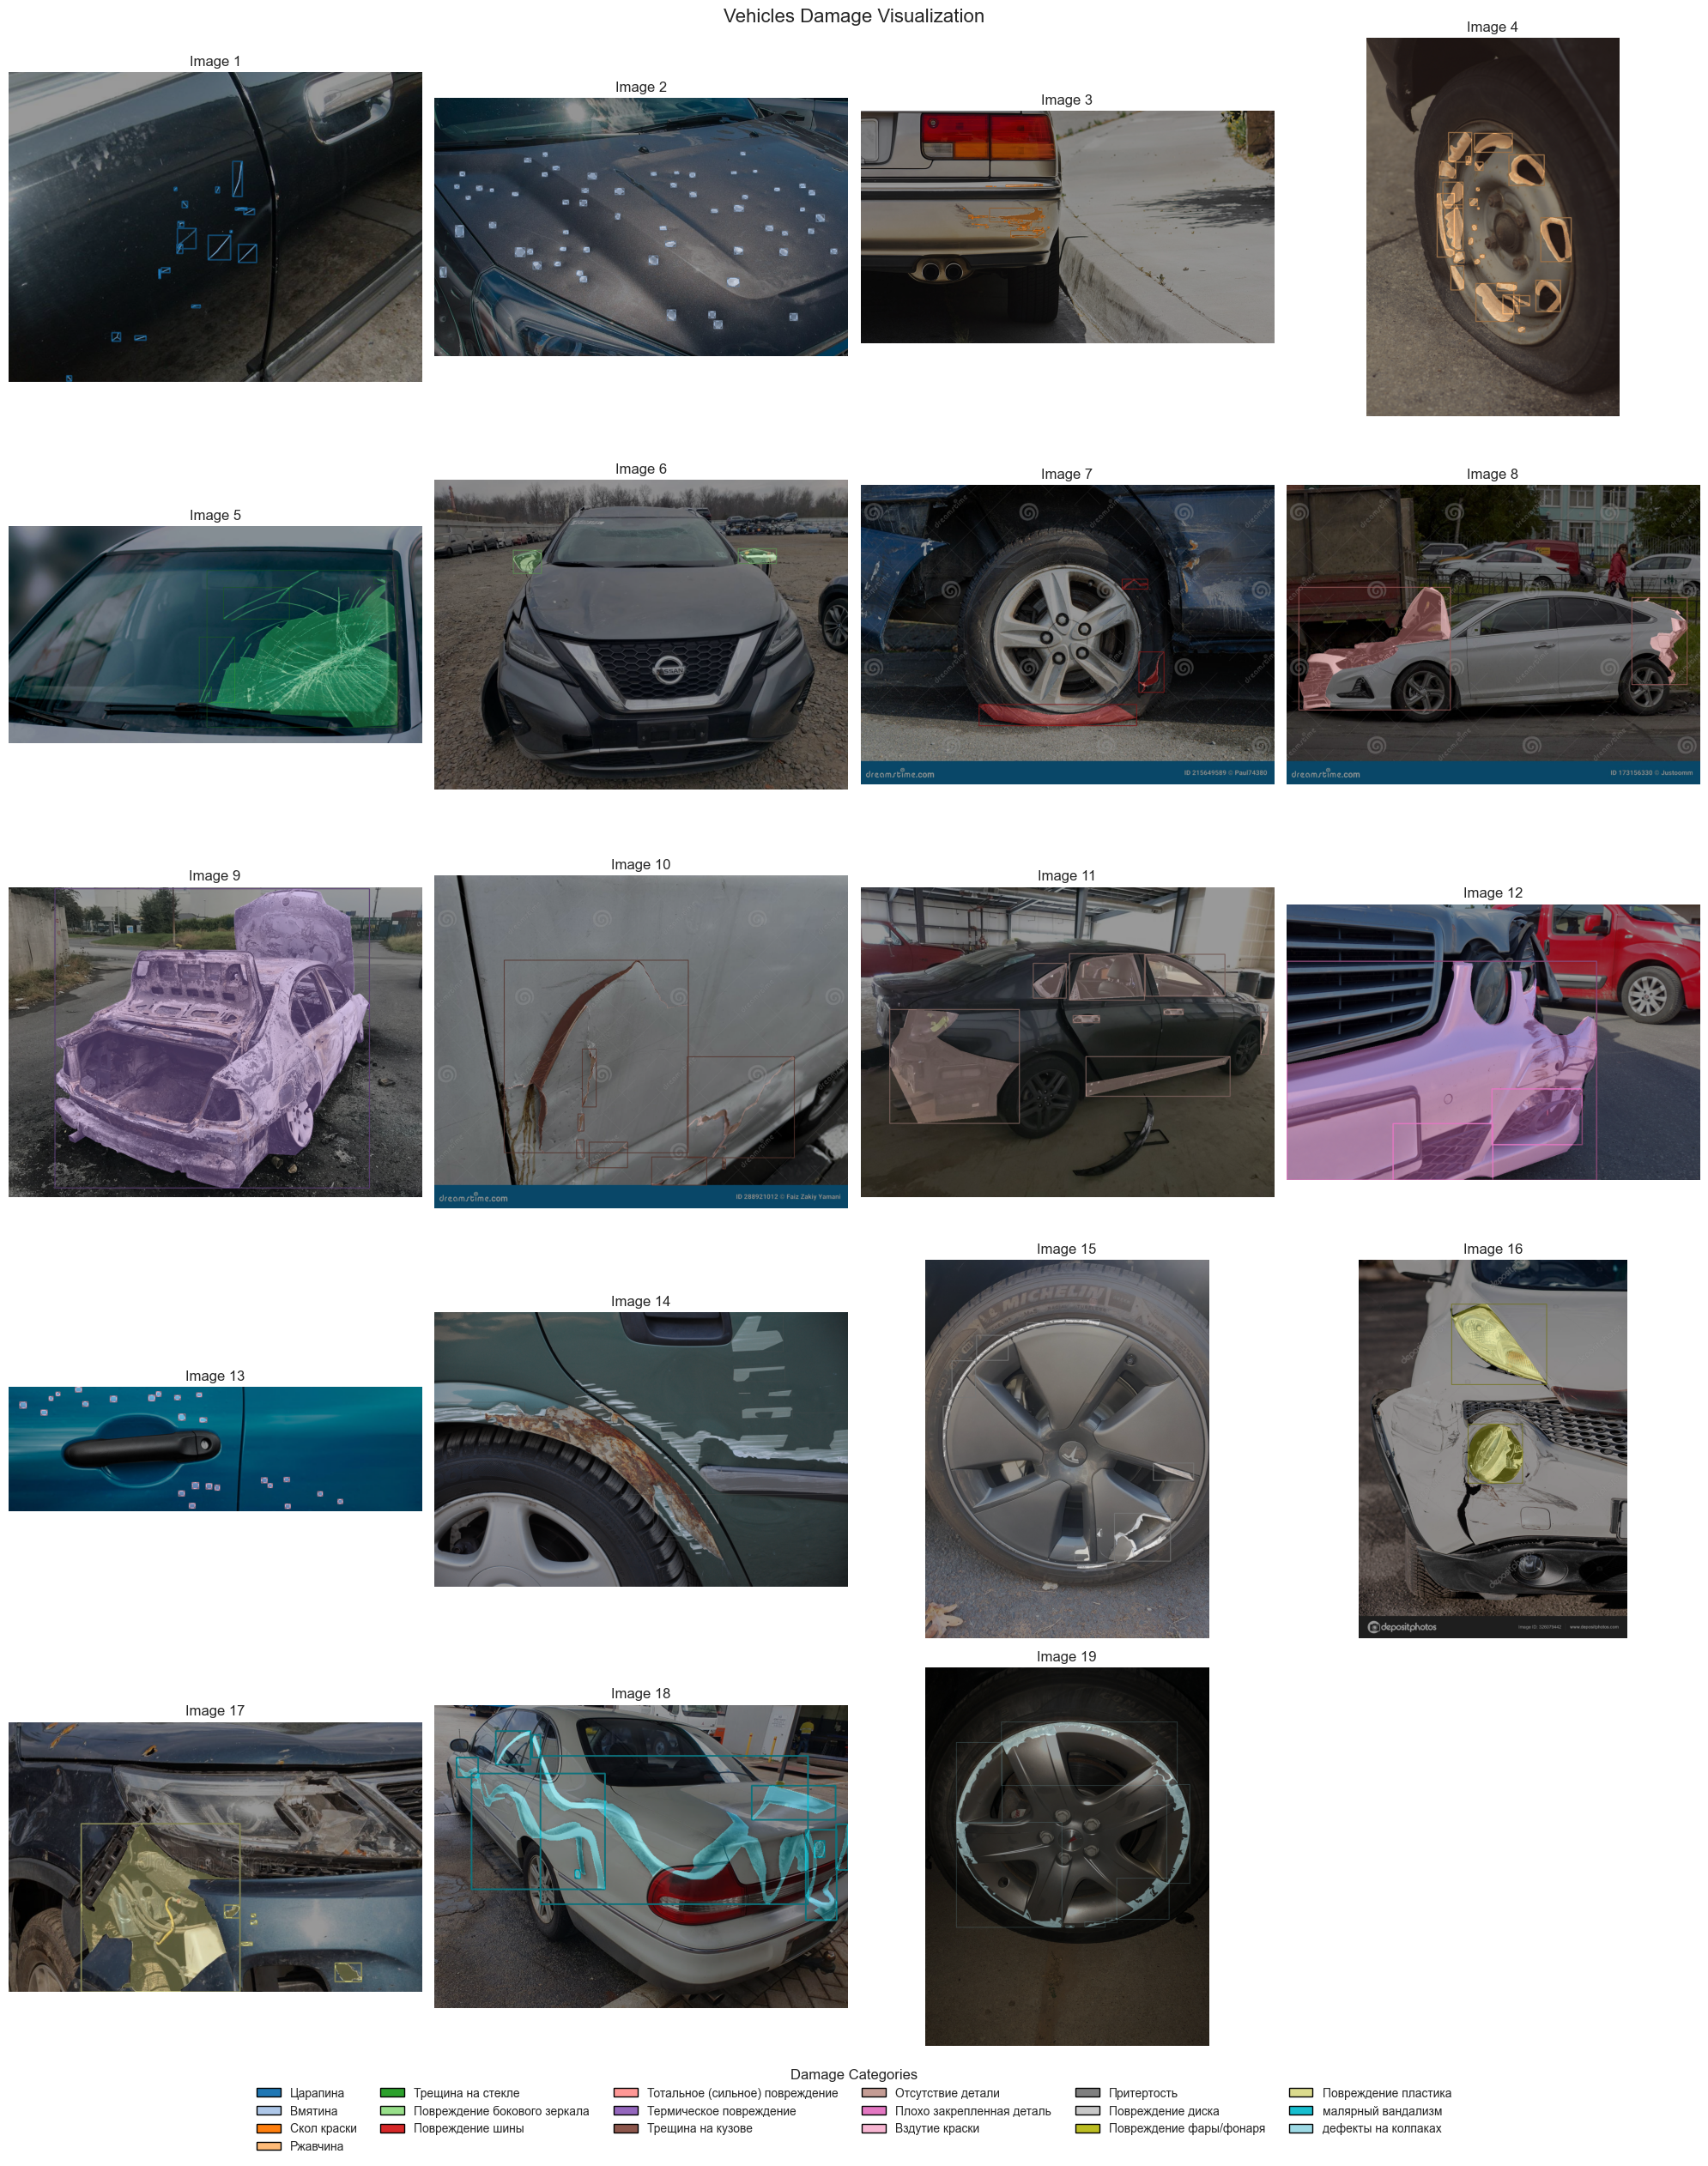

In [5]:
category_colors = create_category_color_palette(cat_id_to_name)

# Group annotations by category
category_annotations = defaultdict(list)
for ann in annotations:
    category_annotations[ann["category_id"]].append(ann)

# Select representative images for each category
selected_images = {}
for cat_id, anns in category_annotations.items():
    image_anns = defaultdict(list)
    for ann in anns:
        image_anns[ann["image_id"]].append(ann)
    sorted_images = sorted(image_anns.items(), key=lambda x: len(x[1]), reverse=True)
    selected_images[cat_id] = sorted_images[:MAX_IMAGES_PER_CLASS]

# Create subplot grid
n_categories = len(cat_id_to_name)
n_cols = 4
n_rows = (n_categories + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes]
plot_idx = 0
for cat_id in cat_id_to_name.keys():
    if plot_idx >= len(axes):
        break
    ax = axes[plot_idx]
    image_id, image_anns = selected_images[cat_id][0]
    image_info = img_id_to_info[image_id]

    # Load and display image
    img_path = f"{IMAGES_DIR}/{image_info['file_name']}"
    img = Image.open(img_path).convert("RGB")
    img_array = np.array(img)

    # Create overlay for masks
    mask_overlay = np.zeros_like(img_array)
    for ann in image_anns:
        color_rgba = category_colors[ann["category_id"]]
        color = tuple(int(c * 255) for c in color_rgba[:3])
        mask = decode_segmentation(ann["segmentation"], image_info["height"], image_info["width"])
        # Create colored mask
        colored_mask = np.zeros_like(img_array)
        colored_mask[mask > 0] = color
        mask_overlay = np.maximum(mask_overlay, colored_mask)
        bbox = ann["bbox"]
        x, y, w, h = bbox
        cv2.rectangle(img_array, (int(x), int(y)), (int(x + w), int(y + h)), color, 2)

    # Blend image with mask overlay
    if mask_overlay.any():
        alpha = 0.4  # Transparency for mask
        blended = cv2.addWeighted(img_array, 1 - alpha, mask_overlay, alpha, 0)
    else:
        blended = img_array

    ax.imshow(blended)
    ax.set_title(f"Image {plot_idx + 1}")
    ax.axis("off")
    plot_idx += 1

# Hide unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].axis("off")

# Create unified legend
legend_elements = []
for cat_id, cat_name in cat_id_to_name.items():
    color_rgba = category_colors[cat_id]
    legend_elements.append(
        plt.Rectangle(
            (0, 0), 1, 1, facecolor=color_rgba, edgecolor="black", linewidth=1, label=cat_name
        )
    )

# Add legend to the figure
fig.legend(
    handles=legend_elements,
    loc="center",
    bbox_to_anchor=(0.5, 0.02),
    ncol=min(len(cat_id_to_name), 6),
    fontsize=10,
    title="Damage Categories",
    title_fontsize=12,
)

plt.tight_layout()
plt.suptitle("Vehicles Damage Visualization", fontsize=16, y=1.0)
plt.subplots_adjust(bottom=0.05)
plt.show()

# Instances/images per class distribution analysis

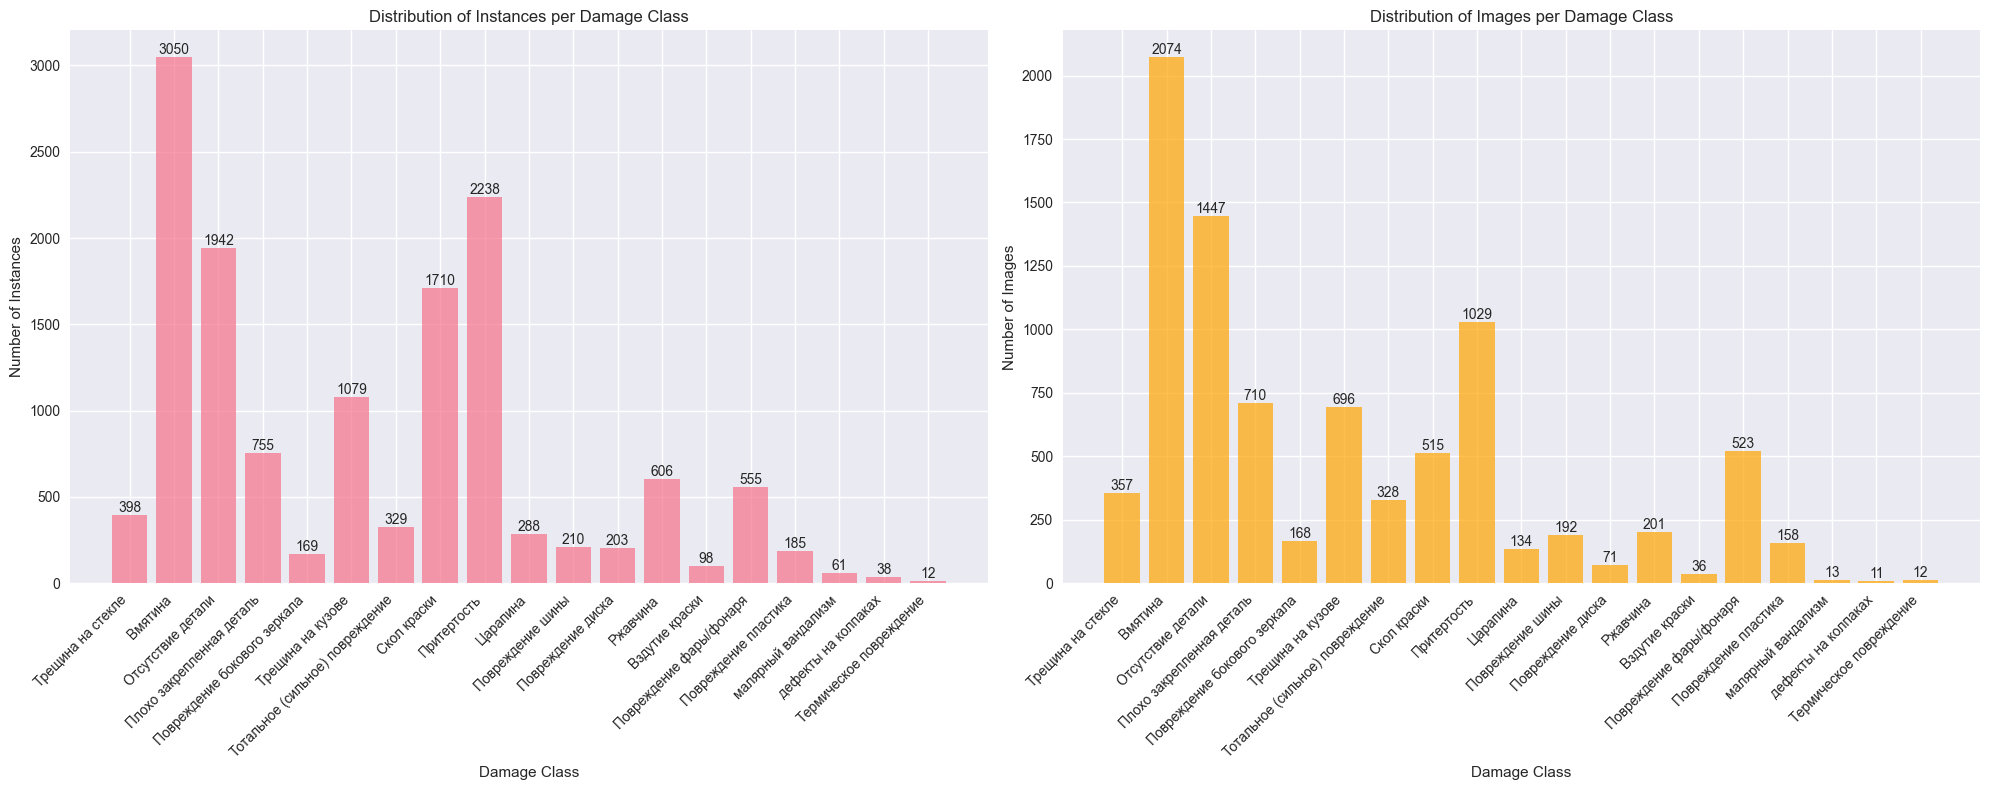

Total instances: 13926
Average instances per class: 732.95
Median instances per class: 329.00
Most common damage: Вмятина (3050 instances)
Least common damage: Термическое повреждение (12 instances)


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Count instances per category
category_counts = Counter(ann["category_id"] for ann in annotations)
categories = [cat_id_to_name[cat_id] for cat_id in category_counts.keys()]
counts = list(category_counts.values())

# Plot number of instances per class
bars1 = ax1.bar(range(len(categories)), counts, alpha=0.7)
ax1.set_xlabel("Damage Class")
ax1.set_ylabel("Number of Instances")
ax1.set_title("Distribution of Instances per Damage Class")
ax1.set_xticks(range(len(categories)))
ax1.set_xticklabels(categories, rotation=45, ha="right")
for bar, count in zip(bars1, counts, strict=False):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2.0, height, f"{count}", ha="center", va="bottom")

# Count images per category
image_category_counts = defaultdict(set)
for ann in annotations:
    image_category_counts[ann["category_id"]].add(ann["image_id"])
image_counts = [len(image_category_counts[cat_id]) for cat_id in category_counts.keys()]

# Plot number of images per class
bars2 = ax2.bar(range(len(categories)), image_counts, alpha=0.7, color="orange")
ax2.set_xlabel("Damage Class")
ax2.set_ylabel("Number of Images")
ax2.set_title("Distribution of Images per Damage Class")
ax2.set_xticks(range(len(categories)))
ax2.set_xticklabels(categories, rotation=45, ha="right")
for bar, count in zip(bars2, image_counts, strict=False):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2.0, height, f"{count}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

print(f"Total instances: {sum(counts)}")
print(f"Average instances per class: {np.mean(counts):.2f}")
print(f"Median instances per class: {np.median(counts):.2f}")
print(f"Most common damage: {categories[np.argmax(counts)]} ({max(counts)} instances)")
print(f"Least common damage: {categories[np.argmin(counts)]} ({min(counts)} instances)")

# Objects sizes distribution analysis

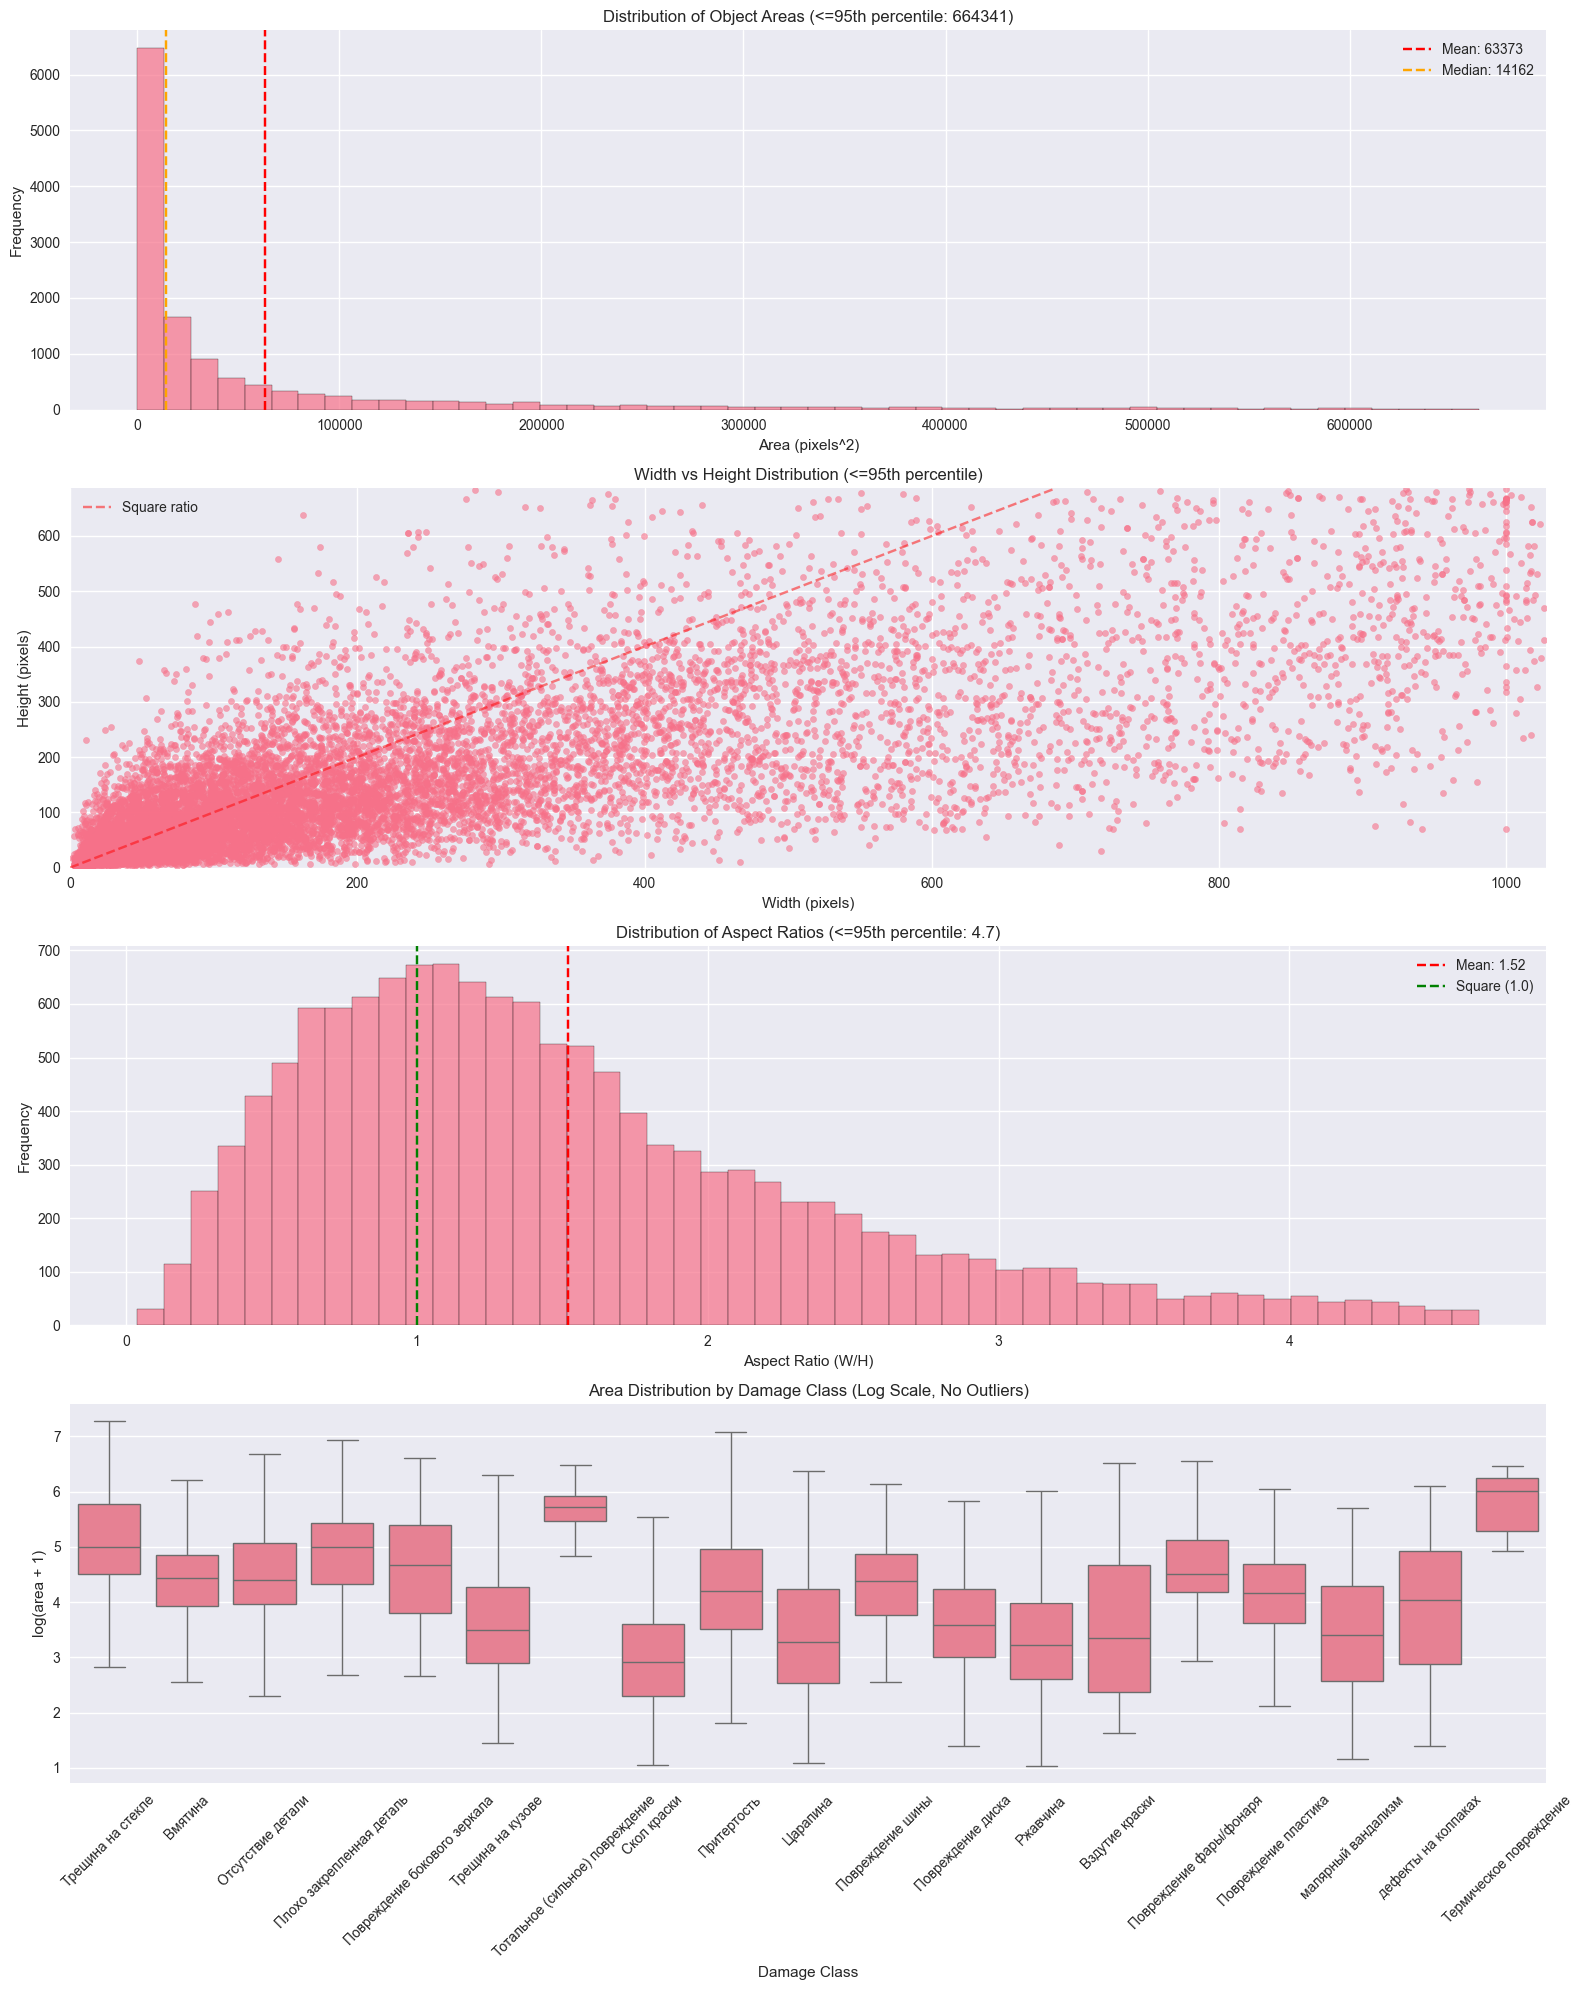

Total objects: 13926
Average area: 169195.93 pixels^2
Median area: 16325.34 pixels^2
95th percentile area: 664341.06 pixels^2
Area range: 10 - 18645488 pixels^2
Objects > 95th percentile: 697 (5.0%)

Average width: 304.53 pixels
Average height: 205.62 pixels
Average aspect ratio: 1.84
Median aspect ratio: 1.37

Largest objects (area > 95th percentile):
  1. Трещина на стекле: 18645488 pixels^2
  2. Тотальное (сильное) повреждение: 18417446 pixels^2
  3. Плохо закрепленная деталь: 12704347 pixels^2
  4. Притертость: 12192768 pixels^2
  5. Повреждение фары/фонаря: 12192768 pixels^2


In [7]:
areas = []
widths = []
heights = []
aspect_ratios = []
categories_for_size = []
for ann in annotations:
    bbox = ann["bbox"]
    w, h = bbox[2], bbox[3]
    area = w * h
    aspect_ratio = w / h if h > 0 else 0
    areas.append(area)
    widths.append(w)
    heights.append(h)
    aspect_ratios.append(aspect_ratio)
    categories_for_size.append(cat_id_to_name[ann["category_id"]])

# Calculate percentiles for better scaling
area_95th = np.percentile(areas, 95)
width_95th = np.percentile(widths, 95)
height_95th = np.percentile(heights, 95)
aspect_95th = np.percentile(aspect_ratios, 95)

fig, axes = plt.subplots(4, 1, figsize=(16, 20))

# Plot area distribution
areas_filtered = [a for a in areas if a <= area_95th]
axes[0].hist(areas_filtered, bins=50, alpha=0.7, edgecolor="black")
axes[0].set_xlabel("Area (pixels^2)")
axes[0].set_ylabel("Frequency")
axes[0].set_title(f"Distribution of Object Areas (<=95th percentile: {area_95th:.0f})")
axes[0].axvline(
    np.mean(areas_filtered),
    color="red",
    linestyle="--",
    label=f"Mean: {np.mean(areas_filtered):.0f}",
)
axes[0].axvline(
    np.median(areas_filtered),
    color="orange",
    linestyle="--",
    label=f"Median: {np.median(areas_filtered):.0f}",
)
axes[0].legend()

# Plot width vs height scatter
widths_filtered = np.array(widths)
heights_filtered = np.array(heights)
mask = (widths_filtered <= width_95th) & (heights_filtered <= height_95th)
scatter = axes[1].scatter(widths_filtered[mask], heights_filtered[mask], alpha=0.6, s=20)
axes[1].set_xlabel("Width (pixels)")
axes[1].set_ylabel("Height (pixels)")
axes[1].set_title("Width vs Height Distribution (<=95th percentile)")
axes[1].set_xlim(0, width_95th)
axes[1].set_ylim(0, height_95th)
max_dim = min(width_95th, height_95th)
axes[1].plot([0, max_dim], [0, max_dim], "r--", alpha=0.5, label="Square ratio")
axes[1].legend()

# Plot aspect ratio distribution
aspect_ratios_filtered = [ar for ar in aspect_ratios if ar <= aspect_95th and ar > 0]
axes[2].hist(aspect_ratios_filtered, bins=50, alpha=0.7, edgecolor="black")
axes[2].set_xlabel("Aspect Ratio (W/H)")
axes[2].set_ylabel("Frequency")
axes[2].set_title(f"Distribution of Aspect Ratios (<=95th percentile: {aspect_95th:.1f})")
axes[2].axvline(
    np.mean(aspect_ratios_filtered),
    color="red",
    linestyle="--",
    label=f"Mean: {np.mean(aspect_ratios_filtered):.2f}",
)
axes[2].axvline(1.0, color="green", linestyle="--", label="Square (1.0)")
axes[2].legend()

# Make a box plot of areas by category
df_sizes = pd.DataFrame({"category": categories_for_size, "area": areas})

# Use log scale for better visualization of boxplots
df_sizes["log_area"] = np.log10(df_sizes["area"] + 1)  # +1 to handle zero areas
sns.boxplot(
    data=df_sizes, x="category", y="log_area", ax=axes[3], showfliers=False
)  # Hide outliers for cleaner view
axes[3].set_xlabel("Damage Class")
axes[3].set_ylabel("log(area + 1)")
axes[3].set_title("Area Distribution by Damage Class (Log Scale, No Outliers)")
axes[3].tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

print(f"Total objects: {len(areas)}")
print(f"Average area: {np.mean(areas):.2f} pixels^2")
print(f"Median area: {np.median(areas):.2f} pixels^2")
print(f"95th percentile area: {area_95th:.2f} pixels^2")
print(f"Area range: {min(areas):.0f} - {max(areas):.0f} pixels^2")
print(
    f"Objects > 95th percentile: {sum(1 for a in areas if a > area_95th)} ({(sum(1 for a in areas if a > area_95th) / len(areas) * 100):.1f}%)"
)

print(f"\nAverage width: {np.mean(widths):.2f} pixels")
print(f"Average height: {np.mean(heights):.2f} pixels")
print(f"Average aspect ratio: {np.mean(aspect_ratios):.2f}")
print(f"Median aspect ratio: {np.median(aspect_ratios):.2f}")

# Show extreme outliers
large_objects = [(i, a) for i, a in enumerate(areas) if a > area_95th]
if large_objects:
    print("\nLargest objects (area > 95th percentile):")
    for i, (idx, area) in enumerate(sorted(large_objects, key=lambda x: x[1], reverse=True)[:5]):
        cat_name = categories_for_size[idx]
        print(f"  {i + 1}. {cat_name}: {area:.0f} pixels^2")

# Images characteristics analysis

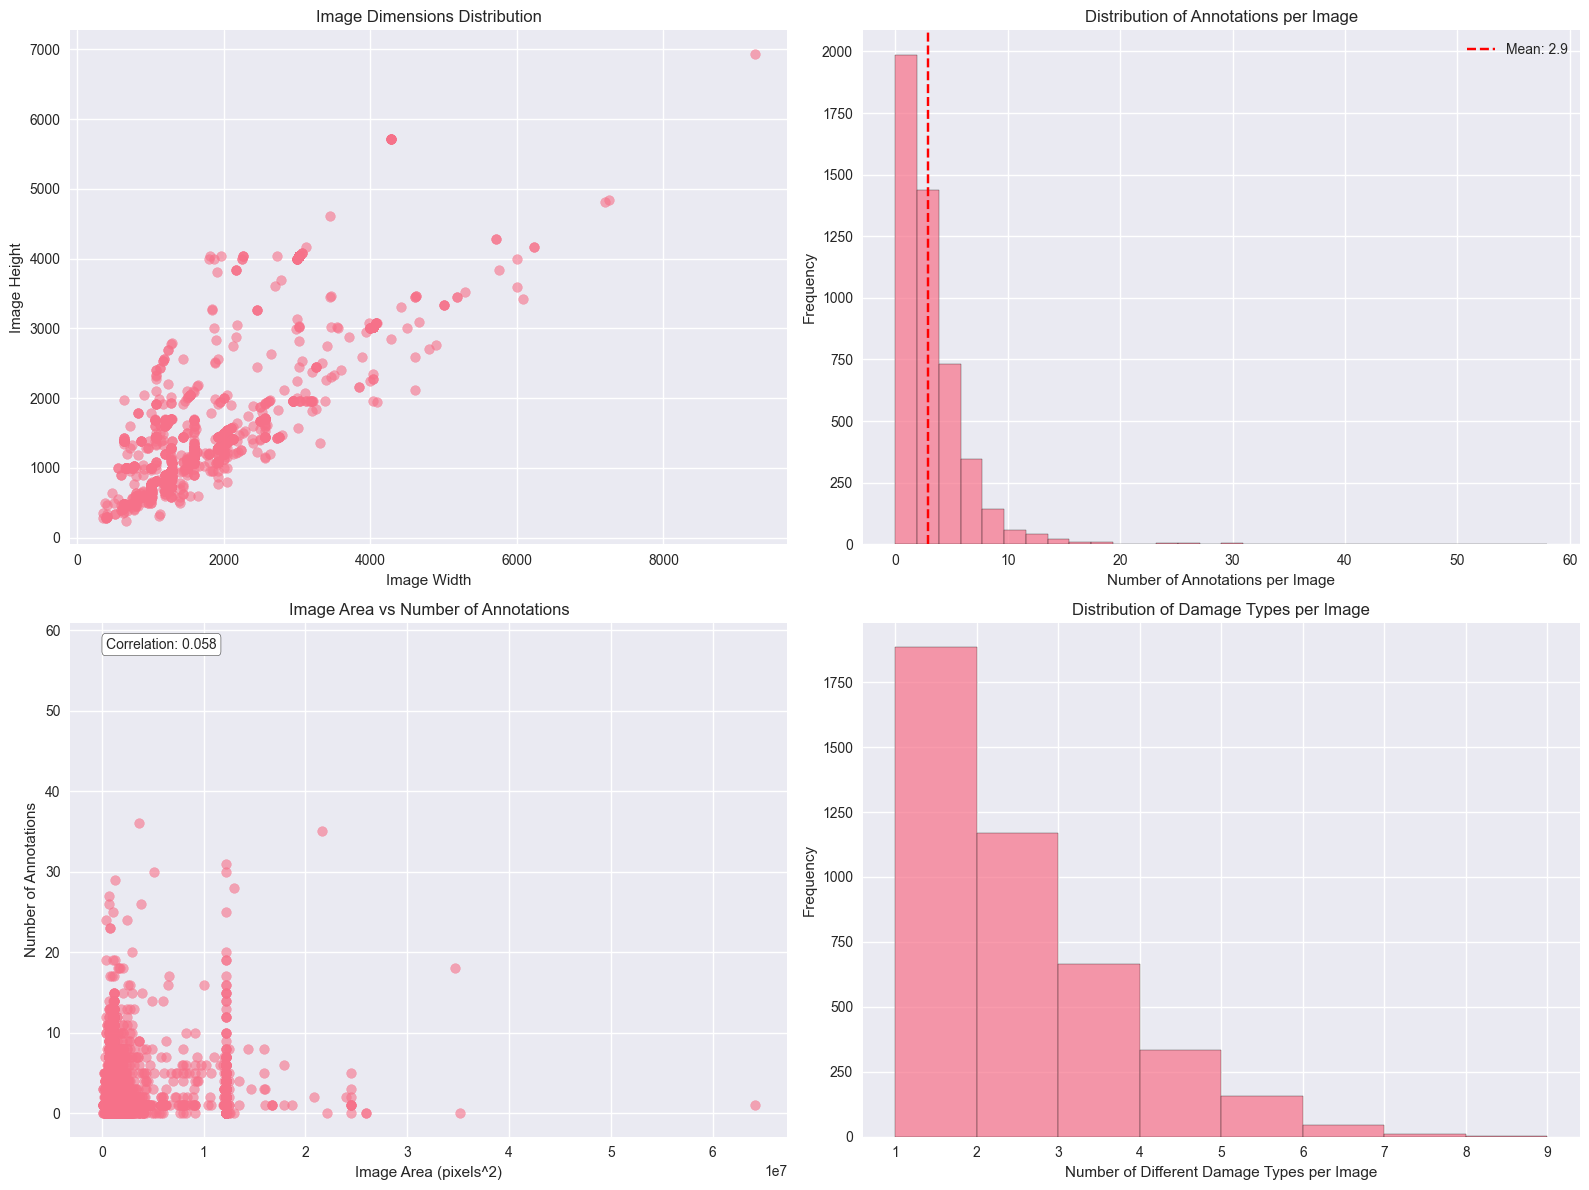

Total images: 4808
Average annotations per image: 2.90
Average damage types per image: 1.80
Images with multiple damage types: 2379
Images with no annotations: 545


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

image_stats = []
for img_info in coco_data["images"]:
    img_id = img_info["id"]
    img_annotations = [ann for ann in annotations if ann["image_id"] == img_id]
    stats = {
        "image_id": img_id,
        "width": img_info["width"],
        "height": img_info["height"],
        "area": img_info["width"] * img_info["height"],
        "aspect_ratio": img_info["width"] / img_info["height"],
        "num_annotations": len(img_annotations),
        "num_categories": len({ann["category_id"] for ann in img_annotations}),
    }
    image_stats.append(stats)

df_images = pd.DataFrame(image_stats)

# Plot image dimensions distribution
axes[0, 0].scatter(df_images["width"], df_images["height"], alpha=0.6)
axes[0, 0].set_xlabel("Image Width")
axes[0, 0].set_ylabel("Image Height")
axes[0, 0].set_title("Image Dimensions Distribution")

# Plot annotations per image
axes[0, 1].hist(df_images["num_annotations"], bins=30, alpha=0.7, edgecolor="black")
axes[0, 1].set_xlabel("Number of Annotations per Image")
axes[0, 1].set_ylabel("Frequency")
axes[0, 1].set_title("Distribution of Annotations per Image")
axes[0, 1].axvline(
    df_images["num_annotations"].mean(),
    color="red",
    linestyle="--",
    label=f"Mean: {df_images['num_annotations'].mean():.1f}",
)
axes[0, 1].legend()

# Plot image area vs number of annotations
axes[1, 0].scatter(df_images["area"], df_images["num_annotations"], alpha=0.6)
axes[1, 0].set_xlabel("Image Area (pixels^2)")
axes[1, 0].set_ylabel("Number of Annotations")
axes[1, 0].set_title("Image Area vs Number of Annotations")

# Add correlation coefficient
corr_coef = np.corrcoef(df_images["area"], df_images["num_annotations"])[0, 1]
axes[1, 0].text(
    0.05,
    0.95,
    f"Correlation: {corr_coef:.3f}",
    transform=axes[1, 0].transAxes,
    bbox={
        "boxstyle": "round",
        "facecolor": "white",
    },
)

# Plot categories per image
axes[1, 1].hist(
    df_images["num_categories"],
    bins=range(1, df_images["num_categories"].max() + 2),
    alpha=0.7,
    edgecolor="black",
)
axes[1, 1].set_xlabel("Number of Different Damage Types per Image")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Distribution of Damage Types per Image")
plt.tight_layout()
plt.show()

print(f"Total images: {len(df_images)}")
print(f"Average annotations per image: {df_images['num_annotations'].mean():.2f}")
print(f"Average damage types per image: {df_images['num_categories'].mean():.2f}")
print(f"Images with multiple damage types: {(df_images['num_categories'] > 1).sum()}")
print(f"Images with no annotations: {(df_images['num_annotations'] == 0).sum()}")

# Classes co-occurrence analysis

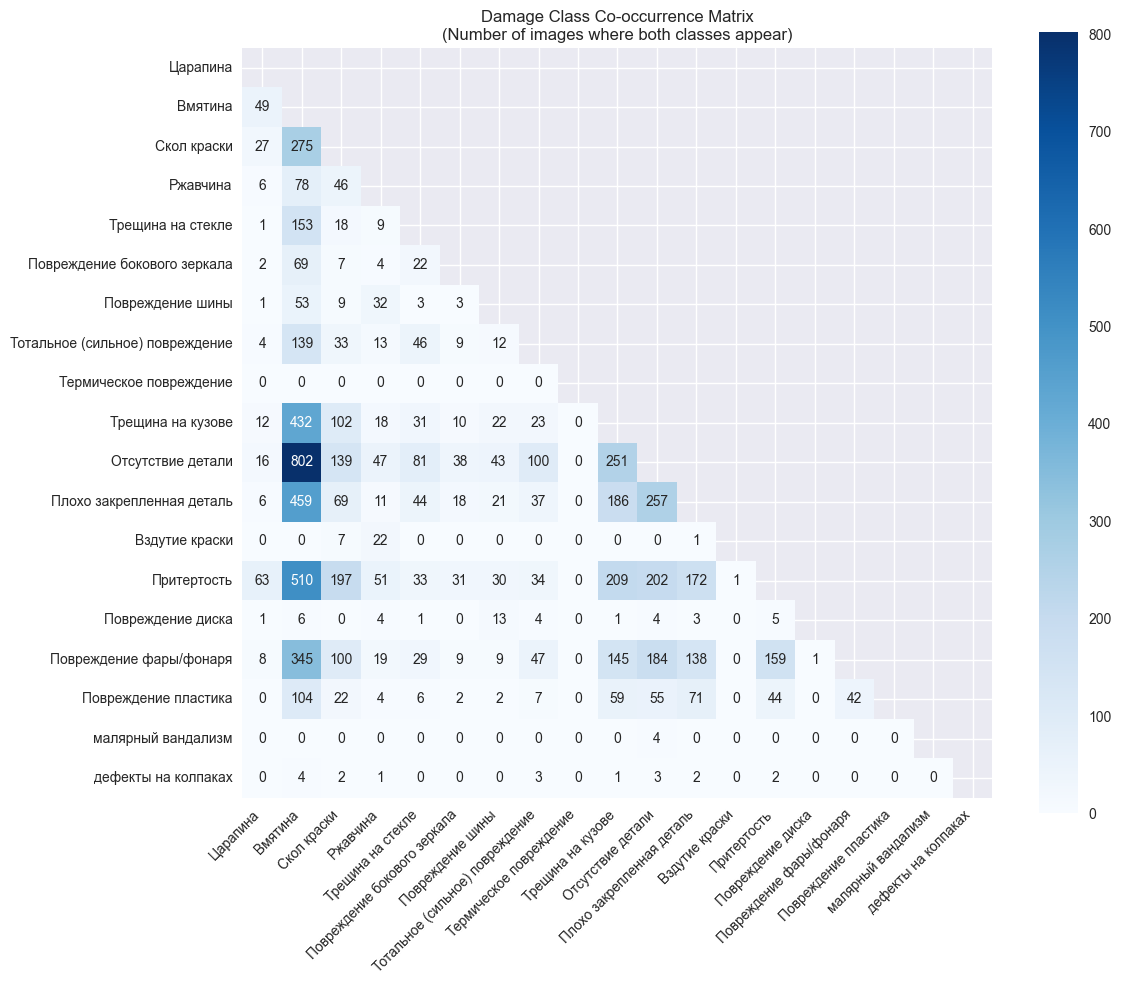

Most Common Damage Co-occurrences:
1. Вмятина + Отсутствие детали: 802.0 images
2. Вмятина + Притертость: 510.0 images
3. Вмятина + Плохо закрепленная деталь: 459.0 images
4. Вмятина + Трещина на кузове: 432.0 images
5. Вмятина + Повреждение фары/фонаря: 345.0 images
6. Вмятина + Скол краски: 275.0 images
7. Отсутствие детали + Плохо закрепленная деталь: 257.0 images
8. Трещина на кузове + Отсутствие детали: 251.0 images
9. Трещина на кузове + Притертость: 209.0 images
10. Отсутствие детали + Притертость: 202.0 images


In [9]:
categories_list = list(cat_id_to_name.keys())
n_categories = len(categories_list)
co_occurrence = np.zeros((n_categories, n_categories))

# Group annotations by image
image_annotations = defaultdict(list)
for ann in annotations:
    image_annotations[ann["image_id"]].append(ann["category_id"])

# Count co-occurrences
for categories_in_image in image_annotations.values():
    categories_in_image = list(set(categories_in_image))  # Remove duplicates
    for i, cat1 in enumerate(categories_list):
        for j, cat2 in enumerate(categories_list):
            if cat1 in categories_in_image and cat2 in categories_in_image:
                co_occurrence[i, j] += 1

category_names = [cat_id_to_name[cat_id] for cat_id in categories_list]

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(co_occurrence, dtype=bool))  # Mask upper triangle
sns.heatmap(
    co_occurrence,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    xticklabels=category_names,
    yticklabels=category_names,
    mask=mask,
    square=True,
)
plt.title("Damage Class Co-occurrence Matrix\n(Number of images where both classes appear)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Find most common co-occurrences
print("Most Common Damage Co-occurrences:")
co_occurrence_pairs = []
for i in range(n_categories):
    for j in range(i + 1, n_categories):
        if co_occurrence[i, j] > 0:
            co_occurrence_pairs.append((category_names[i], category_names[j], co_occurrence[i, j]))

# Sort by frequency
co_occurrence_pairs.sort(key=lambda x: x[2], reverse=True)
for i, (cat1, cat2, count) in enumerate(co_occurrence_pairs[:10]):
    print(f"{i + 1}. {cat1} + {cat2}: {count} images")